# Quadratic Plot toy

We consider data generated according to the following process. 
A latent variable $ x_0 $ is first sampled uniformly from the interval $[-1, 1]$. The corresponding noiseless target is defined as
    $$y_0 = -x_0^2 + 1.$$
Observed samples $(x, y)$ are then obtained by adding independent Gaussian noise:
    $$x \sim \mathcal{N}(x_0, \sigma^2), 
    \qquad 
    y \sim \mathcal{N}(y_0, \sigma^2),
    \qquad
    z = (x,y)$$
where $\sigma > 0$ controls the level of observational noise.

## Imports and Seeds

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import torch
import random
from torch.utils.data import Dataset, DataLoader # to delete later
from scipy.stats import wasserstein_distance

In [2]:
seed = 42
# Python built-in RNG
random.seed(seed)
# NumPy RNG
np.random.seed(seed)

# PyTorch RNG (CPU + CUDA)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

# For reproducibility in cuDNN backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
N = 50000
x_0 = np.random.uniform(low = -1, high = 1, size = (N, ))
y_0 = - x_0**2 + 1
z_0 = np.stack((x_0*0.5+ 0.5, y_0), axis = 1)

training_data = torch.tensor(z_0).unsqueeze(-1).unsqueeze(-1) # images are normalized from 0 to 1

print(f"Training data has shape {training_data.shape} and type {training_data.dtype} with min x {training_data[:,0,:,:].min().item()} max {training_data[:,0,:,:].max().item()}")

torch.save(training_data, f"training_data_{N}.pt")

Training data has shape torch.Size([50000, 2, 1, 1]) and type torch.float64 with min x 5.536675737993768e-06 max 0.9999721473679823


## 

In [4]:
model = Unet(
    dim = 64,
    dim_mults=(1,),
    flash_attn = True,
    channels = 2,          
    out_dim = 2
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 1,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 1000    # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
).cuda()

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [5]:
# trainer = Trainer(
#     diffusion,
#     f'training_data_{N}.pt',
#     is_image = False,
#     train_batch_size = 512,
#     train_lr = 8e-5,
#     train_num_steps = 700,         # total training steps
#     gradient_accumulate_every = 2,    # gradient accumulation steps
#     ema_decay = 0.995,                # exponential moving average decay
#     amp = True,                       # turn on mixed precision
#     calculate_fid = True              # whether to calculate fid during training
# )

# trainer.train()
# torch.save(model.state_dict(), 'model_final.pt')

model.load_state_dict(torch.load('model_final.pt', map_location='cpu'))

<All keys matched successfully>

In [8]:
def plot_and_wass(riemann):
    sampled_images = diffusion.sample(batch_size = 512, riemann = riemann)
    sampled_images.shape # (4, 3, 128, 128)

    sampled_plotting = sampled_images.squeeze(-1).squeeze(-1)
    x = sampled_plotting[:, 0].cpu().numpy()
    y = sampled_plotting[:, 1].cpu().numpy()
    z = np.stack((x, y), axis = 1)
    x_wass = wasserstein_distance(x_0, x)
    y_wass = wasserstein_distance(y_0, y)
    print(x_wass)
    print(y_wass)

    if riemann:
        color = "orange"
    else:
        color = 'blue'
    plt.scatter(x,y, color = color)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

0.5207482083508985
0.013204857460066435


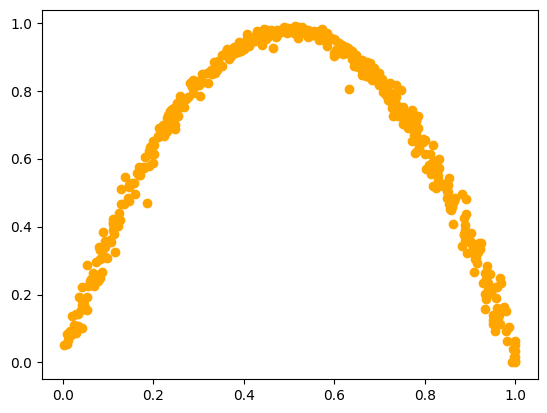

In [9]:
plot_and_wass(True)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

0.5246905769611946
0.02261688002301186


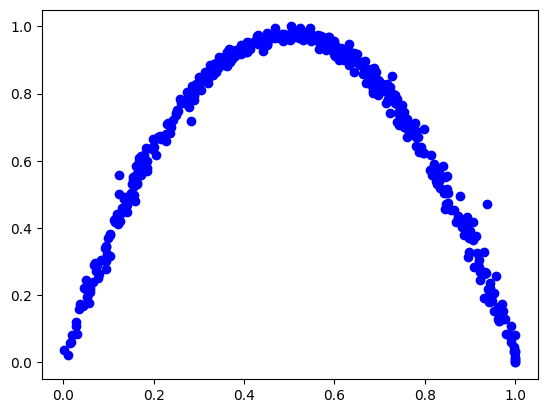

In [10]:
plot_and_wass(False)